# `Part 2/3: Trade data collection with Binance API`

The purpose of this series of notebooks is to showcase real-time candle, trade and order book data collection methods from Binance exchange.

Data is collected through websockets and then stored in SQL databases.

Possible applications of the stored data include:
* creation of custom alerts for discretionary trading 
* development of a fully automated systematic training system based on a set of predetermined rules

#### Author: Vladislav Semin

## 1. Import libraries

In [1]:
import time
import calendar
from datetime import datetime

import pandas as pd #to create a dataframe

import websocket
from binance.client import Client # Import the Binance Client
from binance.websockets import BinanceSocketManager # Import the Binance Socket Manager

import sqlalchemy as db
from sqlalchemy import create_engine

## 2. Setup Binance websocket connection

**IMPORTANT NOTE:** 
This kernel will not run without API keys. Register an account at Binance crypto exchange website to get your API keys:
* https://www.binance.com/en/register

In [2]:
# Input Binance API keys
# PUBLIC = ''
# SECRET = ''

In [3]:
# Setup Binance websocket connection
client = Client(api_key=PUBLIC, api_secret=SECRET)
bm = BinanceSocketManager(client)

## 3. Select cryptocurrency pair

In [4]:
# We will be collecting data for the following cryptocurrency pair
pair = 'ETHBTC'

## 4. Setup SQL database

In [5]:
# Name of SQL database
trade_db = 'binance_trades_{}'.format(pair)

In [6]:
# Set up engine to append the values to the SQL database
engine = create_engine('sqlite:///{}.db'.format(trade_db), echo=False)

## 5. Set up data collection format

In [ ]:
# If we wish create to append trade socket data to python dataframe instead of SQL database, we first create the df:
'''
t_df = pd.DataFrame(columns=["Trade Time", "Trade t-stamp", "Event t-stamp", "Pair", "BUY/SELL",
                                           "Price", "Quantity", "BTC value", "Buyer order ID", "Seller order ID", "Trade ID", 
                                           'Buyer MM', "Event", "Ignore").set_index("Trade Time")
                                           
t_df
'''

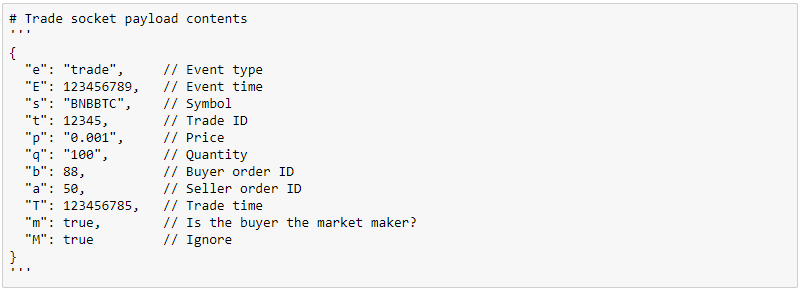

In [7]:
# handle_message is a callback function requested by .start_trade_socket method of BinanceSocketManager class
def handle_message(msg):
    '''
    # import global dataframe into which we will save our data
    global t_df
    '''
    global engine
    global trade_db
    
    if msg['e'] == 'error':    
        print(msg['m'])
        
    else:
        # To calculate the amount of currency exchanged in bitcoins we convert strings to floats.
        btc_exchanged = float(msg['p']) * float(msg['q'])
        
        # Timestamp converted to date time with microseconds
        time = msg['T'] / 1000
        time = datetime.fromtimestamp(time).strftime("%Y-%m-%d %H:%M:%S.%f") 
        
        # Buy or sell?
        # If "m" is true, buyer is the market maker, then someone sold at OB sell price 
        if msg['m'] == True:
            event_side = 'SELL'
        else:
            event_side = 'BUY'
            
        # Streaming trades data
        stream_dict = {"Trade Time": time, "Trade t-stamp": msg['T'], "Event t-stamp": msg['E'],
                       "Pair": msg['s'], "BUY/SELL": event_side,
                       "Price": msg['p'], "Quantity": msg['q'], "BTC value": btc_exchanged,  
                       "Buyer order ID": msg['b'], "Seller order ID": msg['a'], "Trade ID": msg['t'], 
                       'Buyer MM': msg['m'], "Event": msg['e'], 'Ignore': msg['M']}
        
        stream_df = pd.DataFrame([stream_dict]).set_index('Trade Time')  
        
        '''
        # Updating global dataframe
        t_df = t_df.append(stream_df, sort=False)
        '''
        
        # real-time export of streaming dataframes to SQLite database        
        stream_df.to_sql(trade_db, if_exists="append", con=engine)
        
        # Event message acknowledging new trades occurring on the exchange
        print('### {} trade data updated at {}'.format(msg['s'], time))

## 6. Collect trade data

In [8]:
# Connect to collect data
conn_key_trade = bm.start_trade_socket(pair, handle_message)

# Start data collection
bm.start()

# For testing purposes, streaming period is set to 15 seconds. Max connection time is 24 hrs.
time.sleep(15) 

bm.stop_socket(conn_key_trade)

bm.close()

### ETHBTC trade data updated at 2020-04-23 01:42:39.295000
### ETHBTC trade data updated at 2020-04-23 01:42:40.245000
### ETHBTC trade data updated at 2020-04-23 01:42:40.245000
### ETHBTC trade data updated at 2020-04-23 01:42:40.245000
### ETHBTC trade data updated at 2020-04-23 01:42:40.245000
### ETHBTC trade data updated at 2020-04-23 01:42:45.901000


## 7. Check the data appended to SQL database

In [9]:
# Select and show data from the dataframe
binance_trades = engine.execute("SELECT * FROM " + trade_db).fetchall()

# We can see raw SQL data here: 
binance_trades

[('2020-04-23 01:42:39.295000', 1587595359295, 1587595359297, 'ETHBTC', 'SELL', '0.02562800', '0.05300000', 0.001358284, 693655774, 693655963, 173058082, 1, 'trade', 1),
 ('2020-04-23 01:42:40.245000', 1587595360245, 1587595360248, 'ETHBTC', 'BUY', '0.02563400', '0.01200000', 0.000307608, 693655970, 693655944, 173058083, 0, 'trade', 1),
 ('2020-04-23 01:42:40.245000', 1587595360245, 1587595360248, 'ETHBTC', 'BUY', '0.02563500', '0.01100000', 0.000281985, 693655970, 693626116, 173058084, 0, 'trade', 1),
 ('2020-04-23 01:42:40.245000', 1587595360245, 1587595360248, 'ETHBTC', 'BUY', '0.02563500', '0.61600000', 0.015791160000000002, 693655970, 693655938, 173058085, 0, 'trade', 1),
 ('2020-04-23 01:42:40.245000', 1587595360245, 1587595360248, 'ETHBTC', 'BUY', '0.02563500', '0.66200000', 0.016970370000000002, 693655970, 693655939, 173058086, 0, 'trade', 1),
 ('2020-04-23 01:42:45.901000', 1587595365901, 1587595365902, 'ETHBTC', 'BUY', '0.02563500', '1.07000000', 0.027429450000000005, 6936560

In [10]:
# Or we can transform SQL data into pandas dataframe
df = pd.DataFrame(binance_trades, columns=["Trade Time", "Trade t-stamp", "Event t-stamp", "Pair", "BUY/SELL",
                                           "Price", "Quantity", "BTC value", "Buyer order ID", "Seller order ID", "Trade ID", 
                                           'Buyer MM', "Event", "Ignore"]).set_index("Trade Time")

df.head()

,Trade t-stamp,Event t-stamp,Pair,BUY/SELL,Price,Quantity,BTC value,Buyer order ID,Seller order ID,Trade ID,Buyer MM,Event,Ignore
Trade Time,,,,,,,,,,,,,
2020-04-23 01:42:39.295000,1587595359295,1587595359297,ETHBTC,SELL,0.02562800,0.05300000,0.001358,693655774,693655963,173058082,1,trade,1
2020-04-23 01:42:40.245000,1587595360245,1587595360248,ETHBTC,BUY,0.02563400,0.01200000,0.000308,693655970,693655944,173058083,0,trade,1
2020-04-23 01:42:40.245000,1587595360245,1587595360248,ETHBTC,BUY,0.02563500,0.01100000,0.000282,693655970,693626116,173058084,0,trade,1
2020-04-23 01:42:40.245000,1587595360245,1587595360248,ETHBTC,BUY,0.02563500,0.61600000,0.015791,693655970,693655938,173058085,0,trade,1
2020-04-23 01:42:40.245000,1587595360245,1587595360248,ETHBTC,BUY,0.02563500,0.66200000,0.016970,693655970,693655939,173058086,0,trade,1


In [ ]:
'''
# In case data was initially appended to pandas dataframe and not to SQL, we can check the dataframe:
t_df
'''

## References:
#### Binance API Python libraries used in this demonstration:

https://gist.github.com/alexbrillant/961502146a7fc5d03205f9b07b8535f5 - Binance Socket Manager class and its methods

https://github.com/binance-exchange/python-binance